In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np # linear algebra
import pandas as pd

In [3]:
training_set = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/UNSW_NB15_training-set.csv')
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

In [4]:
print(training_set['label'].unique())
print(training_set['attack_cat'].unique())

[0 1]
['Normal' 'Reconnaissance' 'Backdoor' 'DoS' 'Exploits' 'Analysis'
 'Fuzzers' 'Worms' 'Shellcode' 'Generic']


In [5]:
# number of occurrences for each attack category
training_set.attack_cat.value_counts()

Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: attack_cat, dtype: int64

In [6]:

from sklearn import preprocessing
le=preprocessing.LabelEncoder()
num_cat = le.fit_transform(training_set.attack_cat)
print(le.classes_)
print(np.unique(num_cat))

['Analysis' 'Backdoor' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[0 1 2 3 4 5 6 7 8 9]


In [7]:
Y=num_cat.tolist()
X = training_set.drop(columns=['id','attack_cat','label']) 
mask = (X.dtypes == np.object)
list_cat = X.loc[:,mask].columns.tolist()
list_cat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


['proto', 'service', 'state']

In [8]:
X = pd.get_dummies(X, columns=list_cat)
X.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_snmp,service_ssh,service_ssl,state_ACC,state_CLO,state_CON,state_FIN,state_INT,state_REQ,state_RST
0,0.000011,2,0,496,0,90909.0902,254,0,180363632.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1,0.000008,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,0.000005,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,...,0,0,0,0,0,0,0,1,0,0
3,0.000006,2,0,900,0,166666.6608,254,0,600000000.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,0.000010,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,...,0,0,0,0,0,0,0,1,0,0


In [9]:
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(Y), test_size = 0.2, random_state = 42)

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
np.array(y_test).shape

(16467,)

In [12]:
np.array(X_train).shape

(65865, 190)

In [13]:
import pandas as pd
import numpy as np # linear algebra
from numpy import mean
from numpy import std
from numpy import dstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM,GRU,SimpleRNN
from matplotlib import pyplot
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [14]:
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)

In [15]:
X_train = pd.DataFrame(X_train).values.reshape(-1, X_train.shape[1], 1)  # reshaping for convnet
X_test = pd.DataFrame(X_test).values.reshape(-1, X_test.shape[1], 1)  

In [16]:
X_train.shape

(65865, 190, 1)

In [17]:
y_train.shape

(65865, 10)

# IDSSNet - Novel CNN architecture

In [18]:
from keras.layers import Input, Dense, Flatten, AveragePooling2D, Dropout, BatchNormalization, Conv1D,MaxPooling1D,Activation
from tensorflow.keras.activations import relu
epochs, batch_size =  30, 1028
model = Sequential()
# model.add(Dense(2,input_dim=X_train.shape[1], activation="relu"))
model.add(Conv1D(filters=64, kernel_size=3,input_shape=(X_train.shape[1],X_train.shape[2]), activation='relu'))
model.add(Activation(relu))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3,input_shape=(X_train.shape[1],X_train.shape[2]), activation='relu'))
model.add(Activation(relu))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(10,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 188, 64)           256       
                                                                 
 activation (Activation)     (None, 188, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 186, 64)           12352     
                                                                 
 dropout (Dropout)           (None, 186, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 93, 64)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 91, 32)            6176      
                                                        

In [20]:
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test,y_test),batch_size=batch_size,verbose=1)

Epoch 1/30
65/65 [==============================] - 12s 48ms/step - loss: 1.2497 - accuracy: 0.6045 - val_loss: 0.7921 - val_accuracy: 0.7289
Epoch 2/30
65/65 [==============================] - 2s 35ms/step - loss: 0.7708 - accuracy: 0.7348 - val_loss: 0.7105 - val_accuracy: 0.7531
Epoch 3/30
65/65 [==============================] - 2s 35ms/step - loss: 0.6954 - accuracy: 0.7507 - val_loss: 0.6458 - val_accuracy: 0.7783
Epoch 4/30
65/65 [==============================] - 2s 34ms/step - loss: 0.6402 - accuracy: 0.7673 - val_loss: 0.5807 - val_accuracy: 0.7902
Epoch 5/30
65/65 [==============================] - 2s 33ms/step - loss: 0.5879 - accuracy: 0.7851 - val_loss: 0.5312 - val_accuracy: 0.8119
Epoch 6/30
65/65 [==============================] - 2s 35ms/step - loss: 0.5487 - accuracy: 0.8003 - val_loss: 0.5083 - val_accuracy: 0.8244
Epoch 7/30
65/65 [==============================] - 2s 35ms/step - loss: 0.5237 - accuracy: 0.8114 - val_loss: 0.4917 - val_accuracy: 0.8321
Epoch 8/30
6

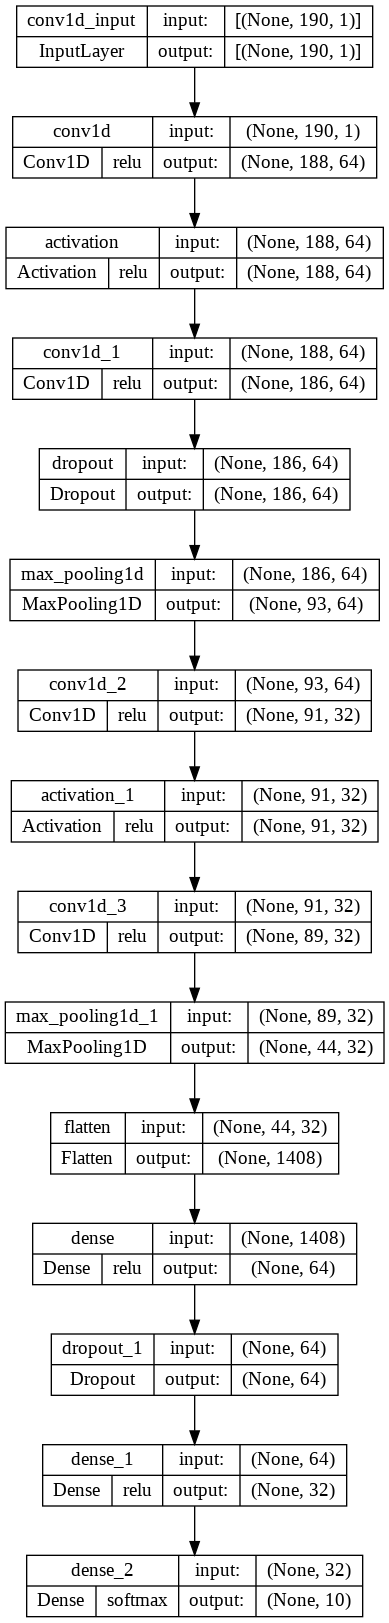

In [21]:
import tensorflow as tf
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

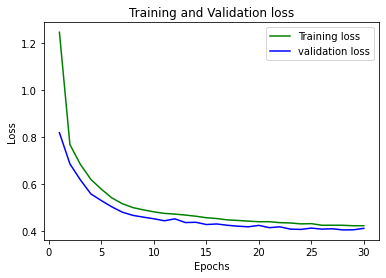

In [ ]:
loss_train = history.history['loss']

import matplotlib.pyplot as plt
loss_val = history.history['val_loss']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

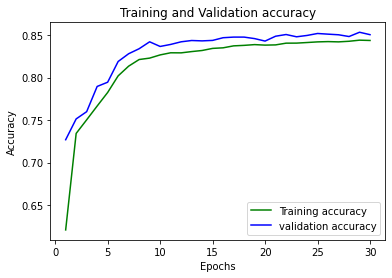

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

515/515 [==============================] - 3s 4ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: Ru

              precision    recall  f1-score   support

           0       0.82      0.07      0.13       131
           1       0.00      0.00      0.00       117
           2       0.43      0.19      0.26       786
           3       0.63      0.77      0.69      2275
           4       0.64      0.67      0.65      1212
           5       1.00      0.96      0.98      3723
           6       0.94      0.96      0.95      7418
           7       0.63      0.75      0.69       723
           8       0.00      0.00      0.00        75
           9       0.00      0.00      0.00         7

    accuracy                           0.85     16467
   macro avg       0.51      0.44      0.44     16467
weighted avg       0.84      0.85      0.84     16467

ACC: 0.0005
Sensitivity: 1.0000
Specificity: nan


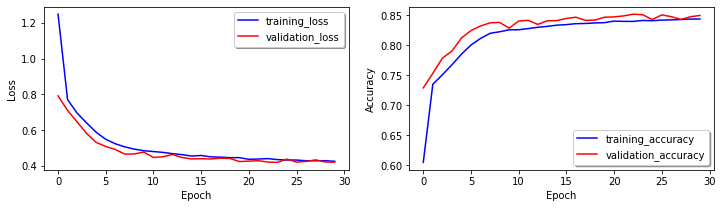

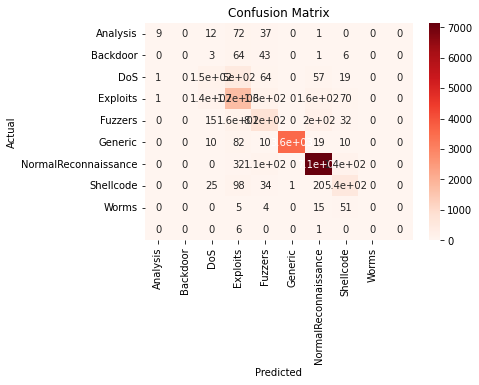

In [25]:
display_history(history)
plot_metrices(model)

# LSTM

In [26]:
from keras.layers import LSTM
model2 = Sequential()
model2.add(LSTM(100, input_shape=(X_train.shape[1],X_train.shape[2])))
model2.add(Dropout(0.5))
model2.add(Dense(124, activation='relu'))
model2.add(Dense(y_train.shape[1], activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
history2 = model2.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test),batch_size=batch_size,verbose=1)

Epoch 1/30
65/65 [==============================] - 7s 55ms/step - loss: 1.7076 - accuracy: 0.4307 - val_loss: 1.5481 - val_accuracy: 0.4505
Epoch 2/30
65/65 [==============================] - 3s 46ms/step - loss: 1.5566 - accuracy: 0.4491 - val_loss: 1.5440 - val_accuracy: 0.4505
Epoch 3/30
65/65 [==============================] - 3s 44ms/step - loss: 1.5440 - accuracy: 0.4490 - val_loss: 1.5028 - val_accuracy: 0.4505
Epoch 4/30
65/65 [==============================] - 3s 45ms/step - loss: 1.3097 - accuracy: 0.5944 - val_loss: 1.0951 - val_accuracy: 0.6679
Epoch 5/30
65/65 [==============================] - 3s 45ms/step - loss: 1.0876 - accuracy: 0.6635 - val_loss: 1.1078 - val_accuracy: 0.6683
Epoch 6/30
65/65 [==============================] - 3s 45ms/step - loss: 1.0312 - accuracy: 0.6710 - val_loss: 1.0426 - val_accuracy: 0.6476
Epoch 7/30
65/65 [==============================] - 3s 45ms/step - loss: 1.0335 - accuracy: 0.6691 - val_loss: 0.9878 - val_accuracy: 0.6788
Epoch 8/30
65

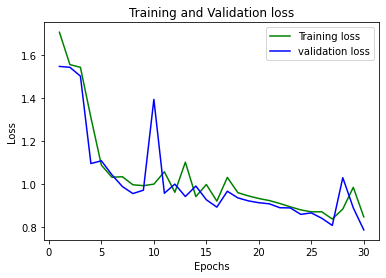

In [28]:
loss_train = history2.history['loss']

import matplotlib.pyplot as plt
loss_val = history2.history['val_loss']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

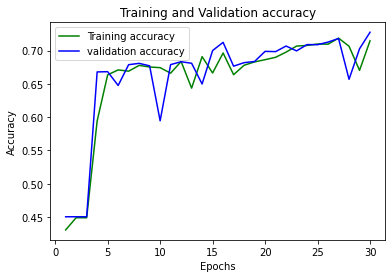

In [29]:
loss_train = history2.history['accuracy']
loss_val = history2.history['val_accuracy']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

515/515 [==============================] - 3s 4ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: Ru

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       131
           1       0.00      0.00      0.00       117
           2       0.33      0.17      0.22       786
           3       0.46      0.56      0.50      2275
           4       0.00      0.00      0.00      1212
           5       0.99      0.97      0.98      3723
           6       0.72      0.94      0.82      7418
           7       0.00      0.00      0.00       723
           8       0.00      0.00      0.00        75
           9       0.00      0.00      0.00         7

    accuracy                           0.73     16467
   macro avg       0.25      0.26      0.25     16467
weighted avg       0.63      0.73      0.67     16467

ACC: 0.0000
Sensitivity: nan
Specificity: nan


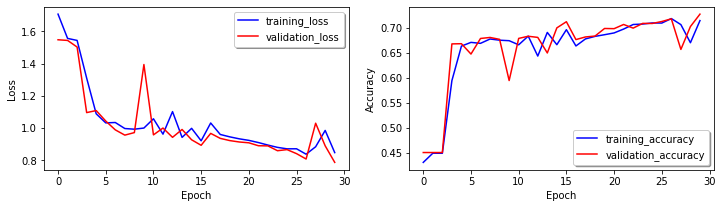

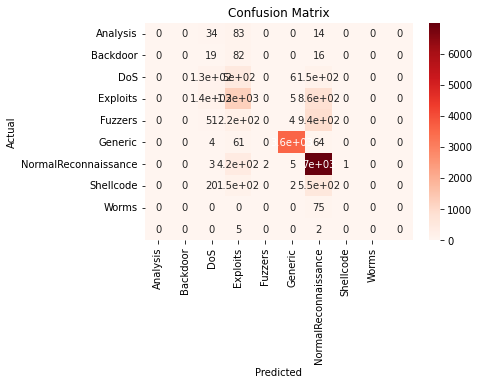

In [30]:
display_history(history2)
plot_metrices(model2)